To summarize the content of this Notebook:
1. Getting data from Spotify using Spotify Web API
2. Data analysis
3. Feature selection
4. Clustering songs using K-Means (and choosing 'k' with the 'Elbow Method')
5. Visualizing these clusters using PCA and t-SNE
6. Insights about each cluster 
7. Using SMOTE to balance data
8. Predicting, with SVM, each songs' cluster

In [1]:
import spotipy #Python library for the Spotify Web API
import seaborn as sns #data visualization
import matplotlib.pyplot as plt #data visualization
import numpy as np #linear algebra
import pandas as pd #data processing 

In [2]:
"""
First, go to https://developer.spotify.com/ and create a client id.
In order not to display my credentials, I created a csv file with them.
You can do the same in your csv file:
    "your-cliend-id-here","your-client-secret-here"
If you don't want to create a csv file just change the value of SPOTIPY_CLIENT_ID and SPOTIPY_CLIENT_SECRET below
with your own credentials (don't forget to comment the line where we're opening the .csv file)
"""
credentials = pd.read_csv('credentials.csv')

SPOTIPY_CLIENT_ID = credentials.columns[0]
SPOTIPY_CLIENT_SECRET = credentials.columns[1]

In [3]:
#Authentication
from spotipy.oauth2 import SpotifyClientCredentials

#spotify object to access API
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(SPOTIPY_CLIENT_ID, 
                                                                             SPOTIPY_CLIENT_SECRET))

In [4]:
user = 'laaragmoura' #your own username here
playlists = spotify.user_playlists(user) 
print(type(playlists))

for key in playlists:
    print(key)
    
print('\n')
while playlists:
    for i, playlist in enumerate(playlists['items']):
        print("%s - %s" % (playlist['uri'],  playlist['name']))
    if playlists['next']:
        playlists = spotify.next(playlists)
    else:
        break

<class 'dict'>
href
items
limit
next
offset
previous
total


spotify:playlist:0gEPUvDXrDsPnEPdUc66v4 - Músicas de Estimação do Momento
spotify:playlist:5fzhYjEP7FEoXZkYrZfd7e - qfpbcc
spotify:playlist:6qpNMKIgqoIAGgrtTjJ9fy - Panic! At The Disco
spotify:playlist:7jnQHsPwPo7aQ4RCY1aEOc - Hype
spotify:playlist:1LFQN6pEFBDYHOlKiAFJ1J - Imagine Dragons
spotify:playlist:0AUhGZBuopuCDIaVA5j9py - tøp


In [5]:
chosen_playlist = '7jnQHsPwPo7aQ4RCY1aEOc' #your own playlist id here
tracks_pt1 = spotify.user_playlist_tracks(user, chosen_playlist, limit=100, offset=0)
tracks_pt2 = spotify.user_playlist_tracks(user, chosen_playlist, limit=100, offset=100)
tracks_pt3 = spotify.user_playlist_tracks(user, chosen_playlist, limit=100, offset=200)
tracklist = tracks_pt1['items'] + tracks_pt2['items'] + tracks_pt3['items']

#Creating data frame with the information from the chosen playlist
data = pd.DataFrame(tracklist)
data

,added_at,added_by,is_local,primary_color,track,video_thumbnail
0,2018-06-08T01:36:38Z,{'external_urls': {'spotify': 'https://open.sp...,False,None,"{'album': {'album_type': 'album', 'artists': [...",{'url': None}
1,2018-06-08T01:37:08Z,{'external_urls': {'spotify': 'https://open.sp...,False,None,"{'album': {'album_type': 'single', 'artists': ...",{'url': None}
2,2018-06-09T00:25:06Z,{'external_urls': {'spotify': 'https://open.sp...,False,None,"{'album': {'album_type': 'album', 'artists': [...",{'url': None}
3,2018-06-08T01:37:12Z,{'external_urls': {'spotify': 'https://open.sp...,False,None,"{'album': {'album_type': 'single', 'artists': ...",{'url': None}
4,2018-06-08T01:39:27Z,{'external_urls': {'spotify': 'https://open.sp...,False,None,"{'album': {'album_type': 'album', 'artists': [...",{'url': None}
...,...,...,...,...,...,...
277,2020-04-06T20:40:20Z,{'external_urls': {'spotify': 'https://open.sp...,False,None,"{'album': {'album_type': 'album', 'artists': [...",{'url': None}
278,2020-04-06T20:55:27Z,{'external_urls': {'spotify': 'https://open.sp...,False,None,"{'album': {'album_type': 'album', 'artists': [...",{'url': None}
279,2020-04-07T00:56:19Z,{'external_urls': {'spotify': 'https://open.sp...,False,None,"{'album': {'album_type': 'album', 'artists': [...",{'url': None}
280,2020-04-07T00:56:28Z,{'external_urls': {'spotify': 'https://open.sp...,False,None,"{'album': {'album_type': 'album', 'artists': [...",{'url': None}


In [6]:
data.columns

Index(['added_at', 'added_by', 'is_local', 'primary_color', 'track',
       'video_thumbnail'],
      dtype='object')

In [7]:
data.iloc[:,4].describe

<bound method NDFrame.describe of 0      {'album': {'album_type': 'album', 'artists': [...
1      {'album': {'album_type': 'single', 'artists': ...
2      {'album': {'album_type': 'album', 'artists': [...
3      {'album': {'album_type': 'single', 'artists': ...
4      {'album': {'album_type': 'album', 'artists': [...
                             ...                        
277    {'album': {'album_type': 'album', 'artists': [...
278    {'album': {'album_type': 'album', 'artists': [...
279    {'album': {'album_type': 'album', 'artists': [...
280    {'album': {'album_type': 'album', 'artists': [...
281    {'album': {'album_type': 'album', 'artists': [...
Name: track, Length: 282, dtype: object>

In [8]:
playlist_info = []
for k,v in enumerate(tracklist):
    info = v['track']
    playlist_info.append((info['name'], info['artists'][0]['name'], info['album']['name'], info['album']['id']))

print(playlist_info)

[('Fluorescent Adolescent', 'Arctic Monkeys', 'Favourite Worst Nightmare', '4jKGRliQXa5VwxKOsiCbfL'), ('My My My!', 'Troye Sivan', 'My My My!', '7wQrwQy96jtQETGmyGzxr8'), ('Tear in My Heart', 'Twenty One Pilots', 'Blurryface', '3cQO7jp5S9qLBoIVtbkSM1'), ('IDGAF', 'Dua Lipa', 'IDGAF', '6ha7AxXJTDHQnwv4UIJhSs'), ('Snap Out Of It', 'Arctic Monkeys', 'AM', '78bpIziExqiI9qztvNFlQu'), ('Bad At Love', 'Halsey', 'hopeless fountain kingdom (Deluxe)', '1fV3TdIojhb9lQXd72HiPq'), ('Sweet Creature', 'Harry Styles', 'Harry Styles', '1FZKIm3JVDCxTchXDo5jOV'), ('Meet Me in the Hallway', 'Harry Styles', 'Harry Styles', '1FZKIm3JVDCxTchXDo5jOV'), ('Dug My Heart', 'BØRNS', 'Dopamine', '1CiO0EwK73UWXiAflI5ZSs'), ('All These Years', 'Camila Cabello', 'Camila', '2vD3zSQr8hNlg0obNel4TE'), ('She Loves Control', 'Camila Cabello', 'Camila', '2vD3zSQr8hNlg0obNel4TE'), ('In the Dark', 'Camila Cabello', 'Camila', '2vD3zSQr8hNlg0obNel4TE'), ('Jumpsuit', 'Twenty One Pilots', 'Jumpsuit / Nico And The Niners', '7lbaLh

In [9]:
playlist_df = pd.DataFrame(playlist_info, columns=('Song', 'Artist', 'Album', 'Id'))
playlist_df.head()

,Song,Artist,Album,Id
0,Fluorescent Adolescent,Arctic Monkeys,Favourite Worst Nightmare,4jKGRliQXa5VwxKOsiCbfL
1,My My My!,Troye Sivan,My My My!,7wQrwQy96jtQETGmyGzxr8
2,Tear in My Heart,Twenty One Pilots,Blurryface,3cQO7jp5S9qLBoIVtbkSM1
3,IDGAF,Dua Lipa,IDGAF,6ha7AxXJTDHQnwv4UIJhSs
4,Snap Out Of It,Arctic Monkeys,AM,78bpIziExqiI9qztvNFlQu


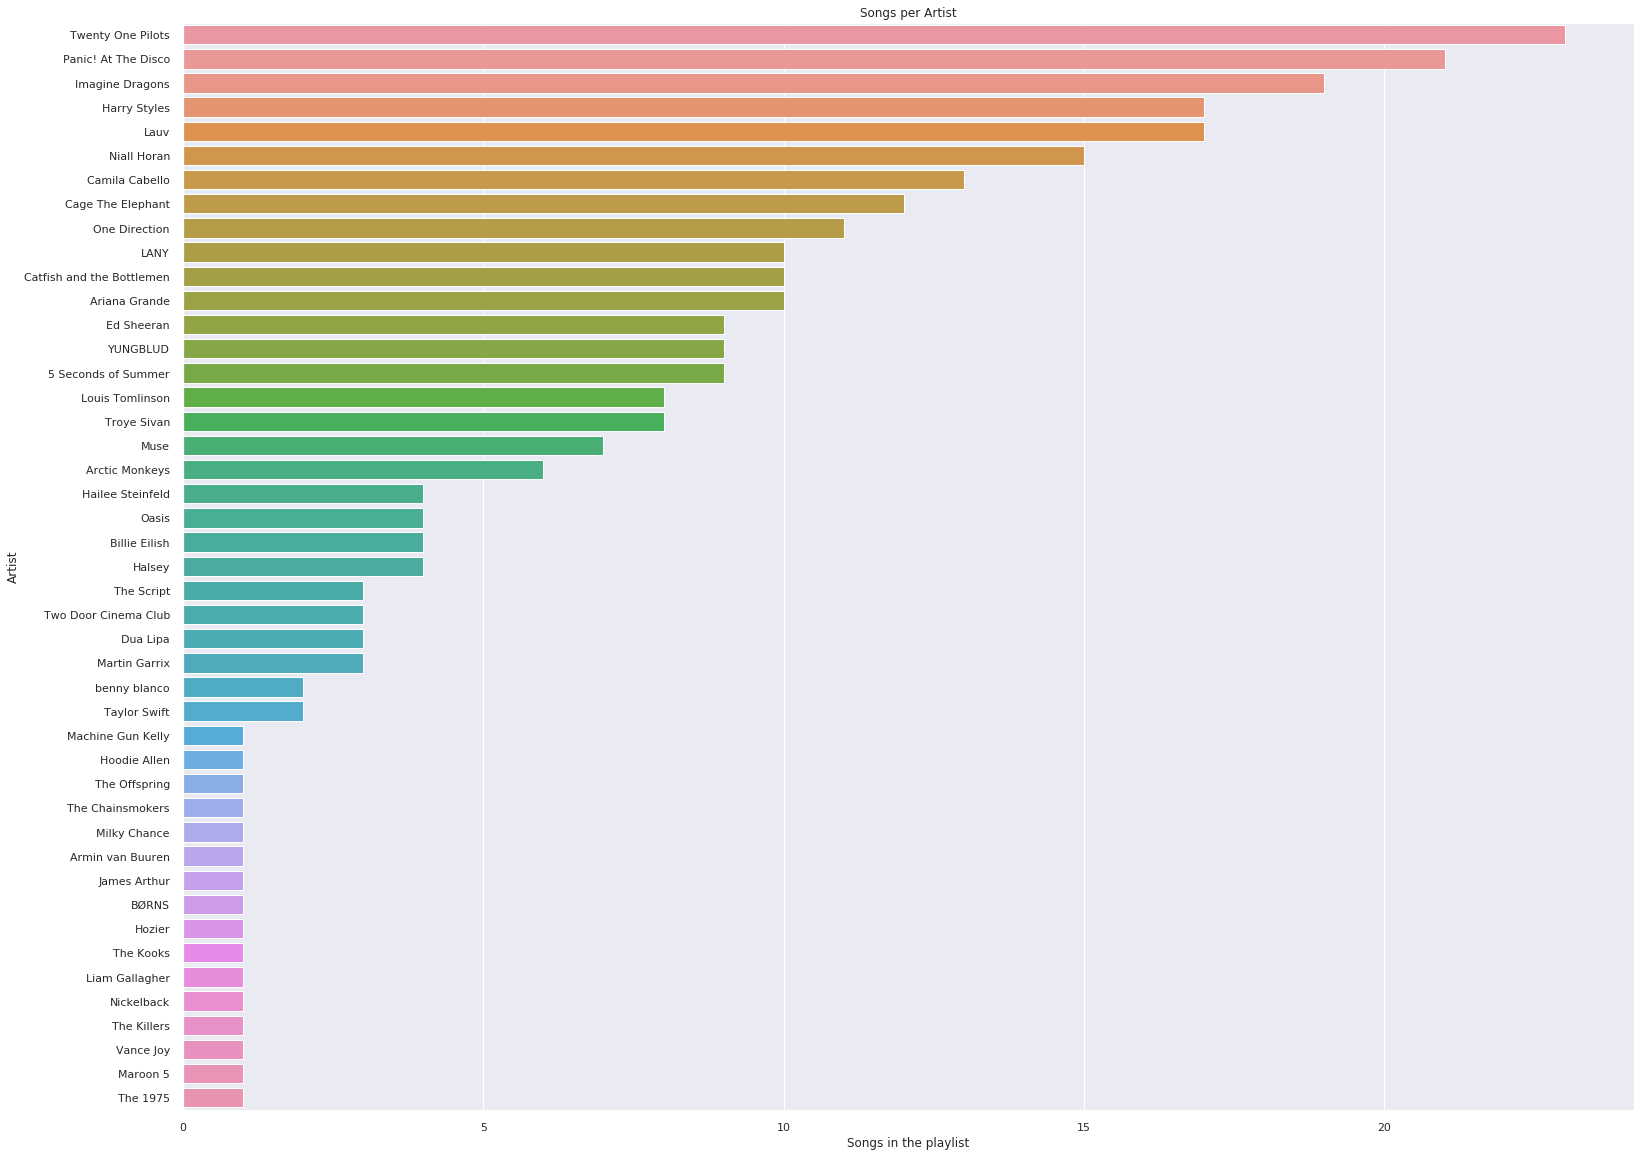

In [39]:
fav_artists = playlist_df['Artist'].value_counts().sort_values(ascending=False).index
ax = sns.countplot(y=playlist_df['Artist'], order=fav_artists)
plt.xlabel('Songs in the playlist')
plt.title('Songs per Artist')
sns.set(rc={'figure.figsize':(26,20)})

Text(0.5, 1.0, 'Songs per Album')

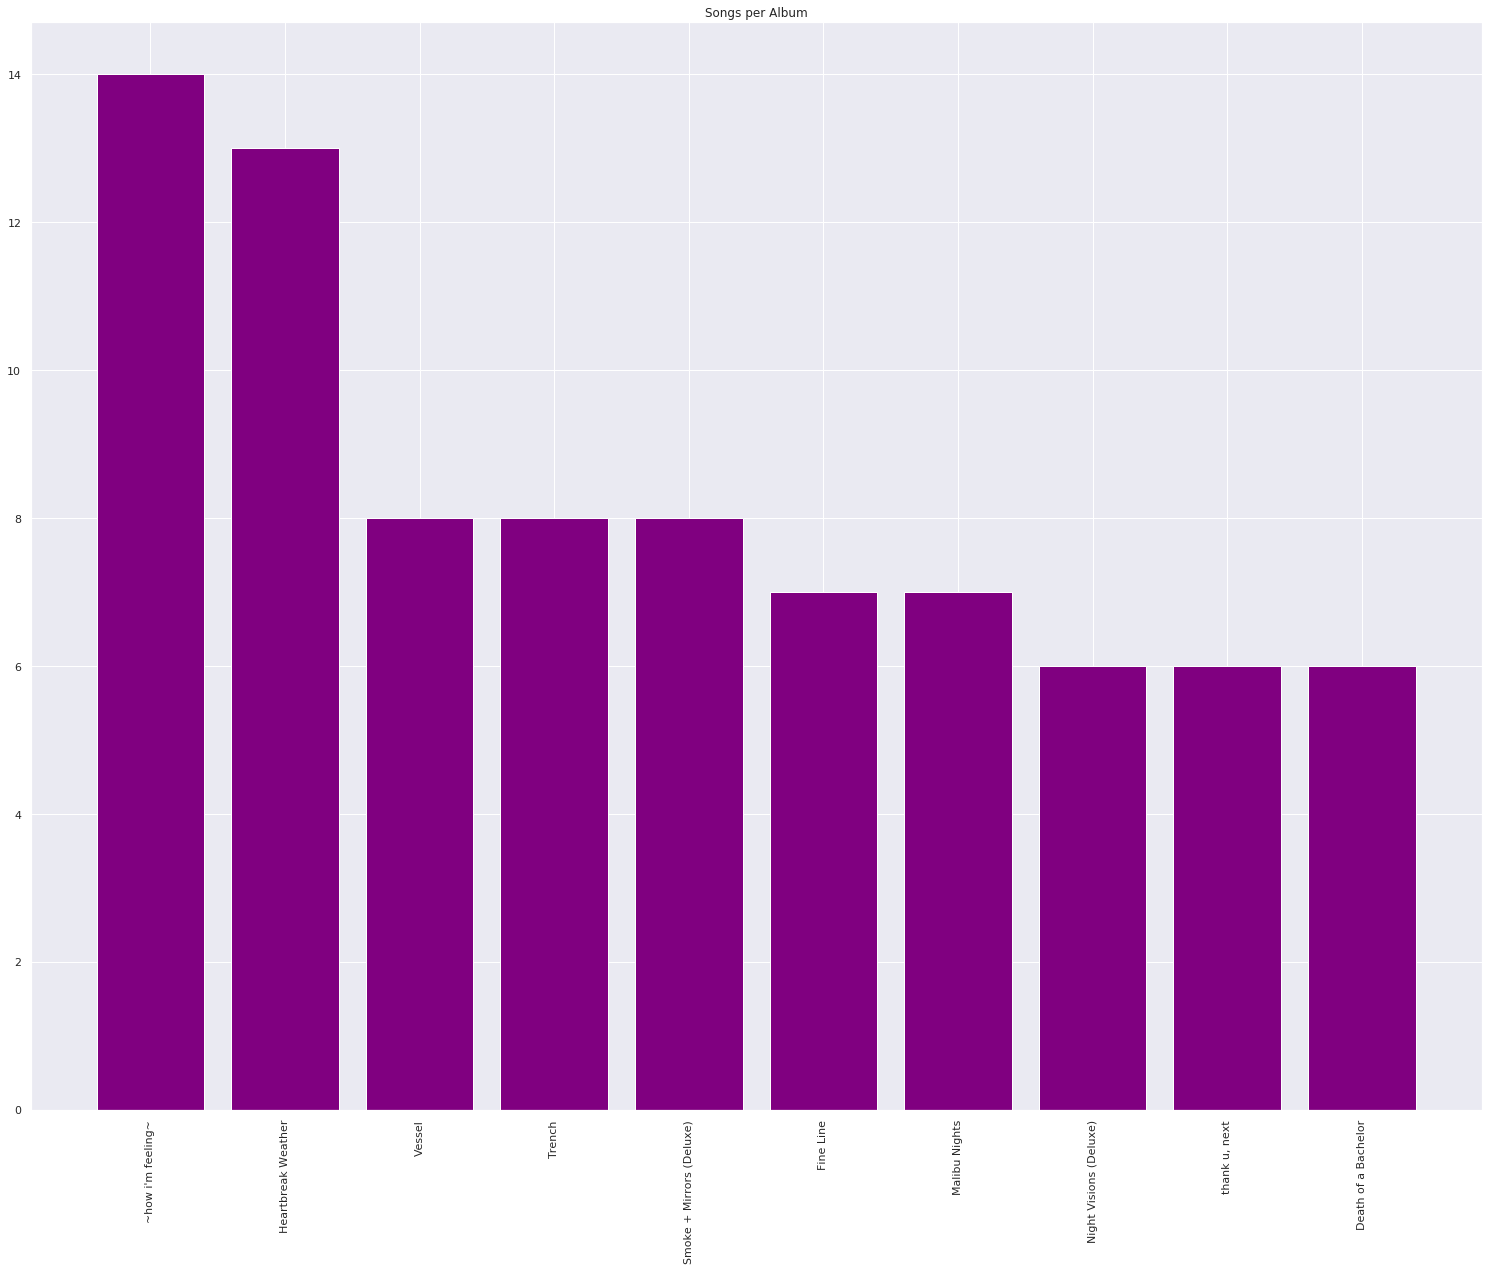

In [11]:
ax = plt.bar(playlist_df['Album'].value_counts().head(10).keys(), playlist_df['Album'].value_counts().head(10),
            color='purple')
plt.xticks(rotation=90)
plt.title('Songs per Album')

In [12]:
#Grabbing audio features for each song
audio_features_names = []
audio_features_ids = []
audio_features_artists = []
#Iterating over 'tracklist' in order to create some lists which will be on our audio features data frame
for k,v in enumerate(tracklist):
    info = v['track']
    audio_features_names.append(info['name'])
    audio_features_ids.append(info['id'])
    audio_features_artists.append(info['artists'][0]['name'])
    
audio_features_pt1 = []
audio_features_pt2 = []
audio_features_pt3 = []
audio_features_pt4 = []
audio_features_pt5 = []
audio_features_pt6 = []
for i in range(len(audio_features_ids)):
    if i < 50:
        audio_features_pt1.append(audio_features_ids[i])
    elif i < 100:
        audio_features_pt2.append(audio_features_ids[i])
    elif i < 150:
        audio_features_pt3.append(audio_features_ids[i])
    elif i < 200:
        audio_features_pt4.append(audio_features_ids[i])
    elif i < 250:
        audio_features_pt5.append(audio_features_ids[i])
    elif i < 300:
        audio_features_pt6.append(audio_features_ids[i])

#Get audio features for one or multiple tracks based upon their Spotify IDs: audio_features(tracks=[])
#tracks - a list of track URIs, URLs or IDs, maximum: 50 ids
audio_features1 = spotify.audio_features(audio_features_pt1)
audio_features2 = spotify.audio_features(audio_features_pt2)
audio_features3 = spotify.audio_features(audio_features_pt3)
audio_features4 = spotify.audio_features(audio_features_pt4)
audio_features5 = spotify.audio_features(audio_features_pt5)
audio_features6 = spotify.audio_features(audio_features_pt6)

audio_features = audio_features1+audio_features2+audio_features3+audio_features4+audio_features5+audio_features6

In [13]:
#Creating audio features data frame
audio_features_df = pd.DataFrame(audio_features) 
audio_features_df.insert(0, "track", audio_features_names, True) #using insert() to add a column to our data frame
audio_features_df.insert(1, "artist", audio_features_artists, True)
audio_features_df.head(10)

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Fluorescent Adolescent,Arctic Monkeys,0.651,0.823,1,-5.148,0,0.0282,0.00193,0.000058,0.1720,0.817,112.148,audio_features,2HYaqJitHc9qiG68vc0JIm,spotify:track:2HYaqJitHc9qiG68vc0JIm,https://api.spotify.com/v1/tracks/2HYaqJitHc9q...,https://api.spotify.com/v1/audio-analysis/2HYa...,179533,4
1,My My My!,Troye Sivan,0.699,0.479,1,-7.830,1,0.0919,0.00433,0.000096,0.0435,0.462,102.959,audio_features,2Tq2R8sRftNEqdgJK5HadO,spotify:track:2Tq2R8sRftNEqdgJK5HadO,https://api.spotify.com/v1/tracks/2Tq2R8sRftNE...,https://api.spotify.com/v1/audio-analysis/2Tq2...,204727,4
2,Tear in My Heart,Twenty One Pilots,0.655,0.632,2,-4.802,1,0.0489,0.01890,0.000000,0.0722,0.447,120.113,audio_features,3bnVBN67NBEzedqQuWrpP4,spotify:track:3bnVBN67NBEzedqQuWrpP4,https://api.spotify.com/v1/tracks/3bnVBN67NBEz...,https://api.spotify.com/v1/audio-analysis/3bnV...,188493,4
3,IDGAF,Dua Lipa,0.836,0.544,7,-5.975,1,0.0943,0.04030,0.000000,0.0824,0.510,97.028,audio_features,5BG3hnp2SmFmoBIs3YTqsm,spotify:track:5BG3hnp2SmFmoBIs3YTqsm,https://api.spotify.com/v1/tracks/5BG3hnp2SmFm...,https://api.spotify.com/v1/audio-analysis/5BG3...,217947,4
4,Snap Out Of It,Arctic Monkeys,0.728,0.638,5,-6.455,0,0.0336,0.24900,0.000000,0.1160,0.872,130.014,audio_features,0NdTUS4UiNYCNn5FgVqKQY,spotify:track:0NdTUS4UiNYCNn5FgVqKQY,https://api.spotify.com/v1/tracks/0NdTUS4UiNYC...,https://api.spotify.com/v1/audio-analysis/0NdT...,193030,4
5,Bad At Love,Halsey,0.664,0.753,0,-3.589,1,0.0323,0.05700,0.000000,0.0880,0.540,118.253,audio_features,2TBQoW7s6iwKcg139ssqie,spotify:track:2TBQoW7s6iwKcg139ssqie,https://api.spotify.com/v1/tracks/2TBQoW7s6iwK...,https://api.spotify.com/v1/audio-analysis/2TBQ...,181279,4
6,Sweet Creature,Harry Styles,0.427,0.262,7,-8.541,1,0.0276,0.74600,0.000000,0.0680,0.228,104.085,audio_features,5kRPPEWFJIMox5qIkQkiz5,spotify:track:5kRPPEWFJIMox5qIkQkiz5,https://api.spotify.com/v1/tracks/5kRPPEWFJIMo...,https://api.spotify.com/v1/audio-analysis/5kRP...,224867,4
7,Meet Me in the Hallway,Harry Styles,0.537,0.383,2,-6.528,1,0.0247,0.74700,0.000250,0.3560,0.339,104.252,audio_features,4u9Y4Z9i9VaAbBK7rW1Rha,spotify:track:4u9Y4Z9i9VaAbBK7rW1Rha,https://api.spotify.com/v1/tracks/4u9Y4Z9i9VaA...,https://api.spotify.com/v1/audio-analysis/4u9Y...,227200,4
8,Dug My Heart,BØRNS,0.568,0.809,9,-5.474,1,0.1010,0.02650,0.000061,0.1100,0.600,166.044,audio_features,4o6LaVzeB3Ny7oQCBjT053,spotify:track:4o6LaVzeB3Ny7oQCBjT053,https://api.spotify.com/v1/tracks/4o6LaVzeB3Ny...,https://api.spotify.com/v1/audio-analysis/4o6L...,189573,4
9,All These Years,Camila Cabello,0.732,0.436,1,-7.409,0,0.1170,0.60900,0.000000,0.1080,0.475,94.852,audio_features,4XLu3tTSZiPFVC9mmuR6Zp,spotify:track:4XLu3tTSZiPFVC9mmuR6Zp,https://api.spotify.com/v1/tracks/4XLu3tTSZiPF...,https://api.spotify.com/v1/audio-analysis/4XLu...,164373,4


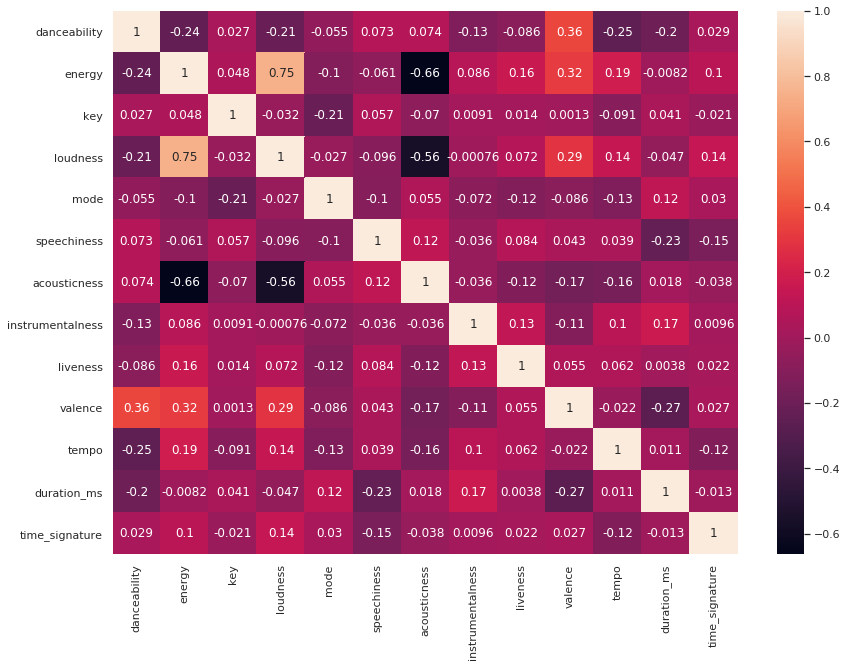

In [14]:
#Feature analysis
correlation_matrix = audio_features_df.corr()
ax = plt.subplots(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True) #annot: if True, write the data value in each cell.
plt.show()

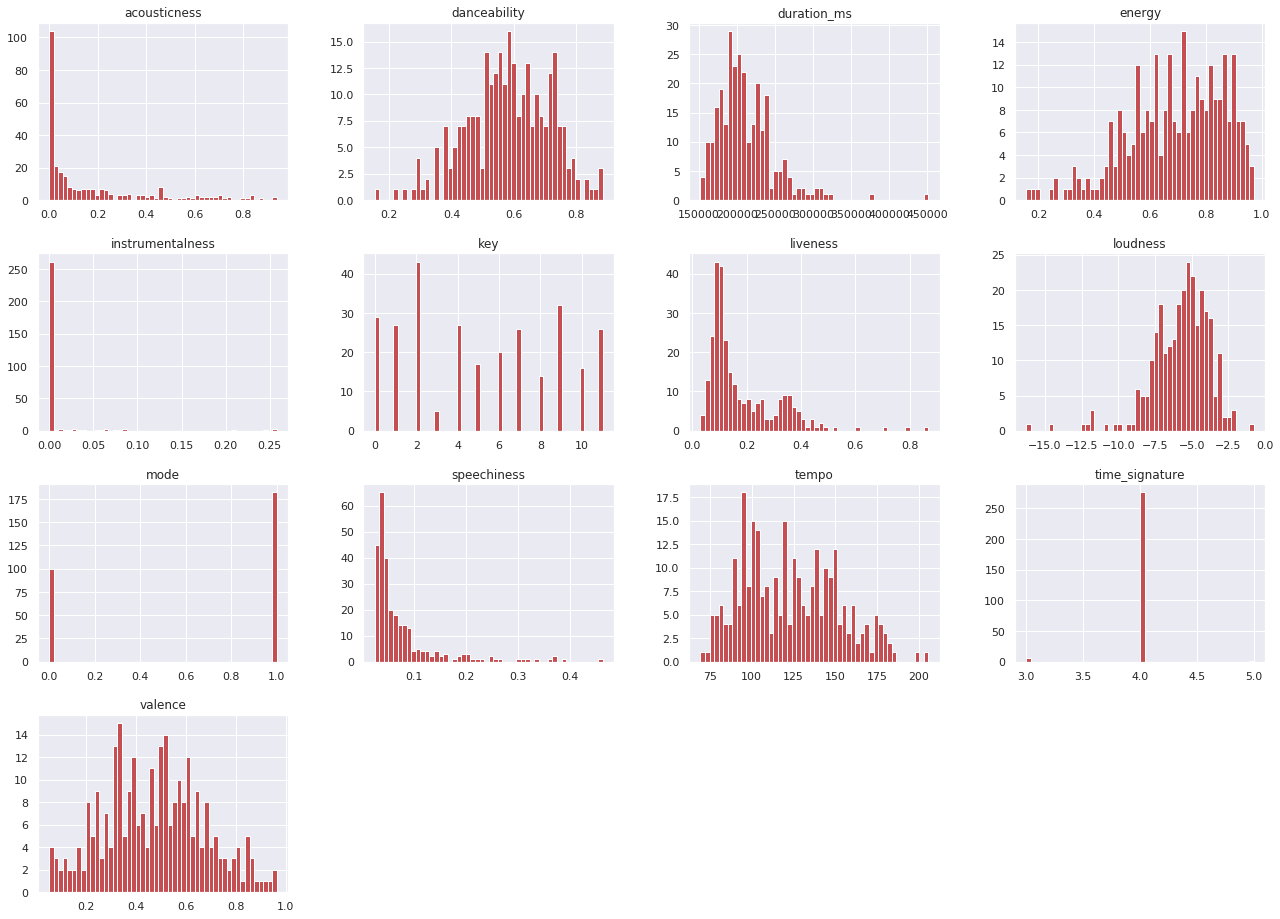

In [15]:
audio_features_df.hist(bins=50, figsize=(22,16), color='r')
plt.show()

In [16]:
#Chosen features (after analyzing both the heatmap and histogram above)
features = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'valence']

audio_features_df.loc[:, features].mean()

danceability        0.581482
energy              0.689674
speechiness         0.075601
acousticness        0.166757
instrumentalness    0.006361
valence             0.471904
dtype: float64

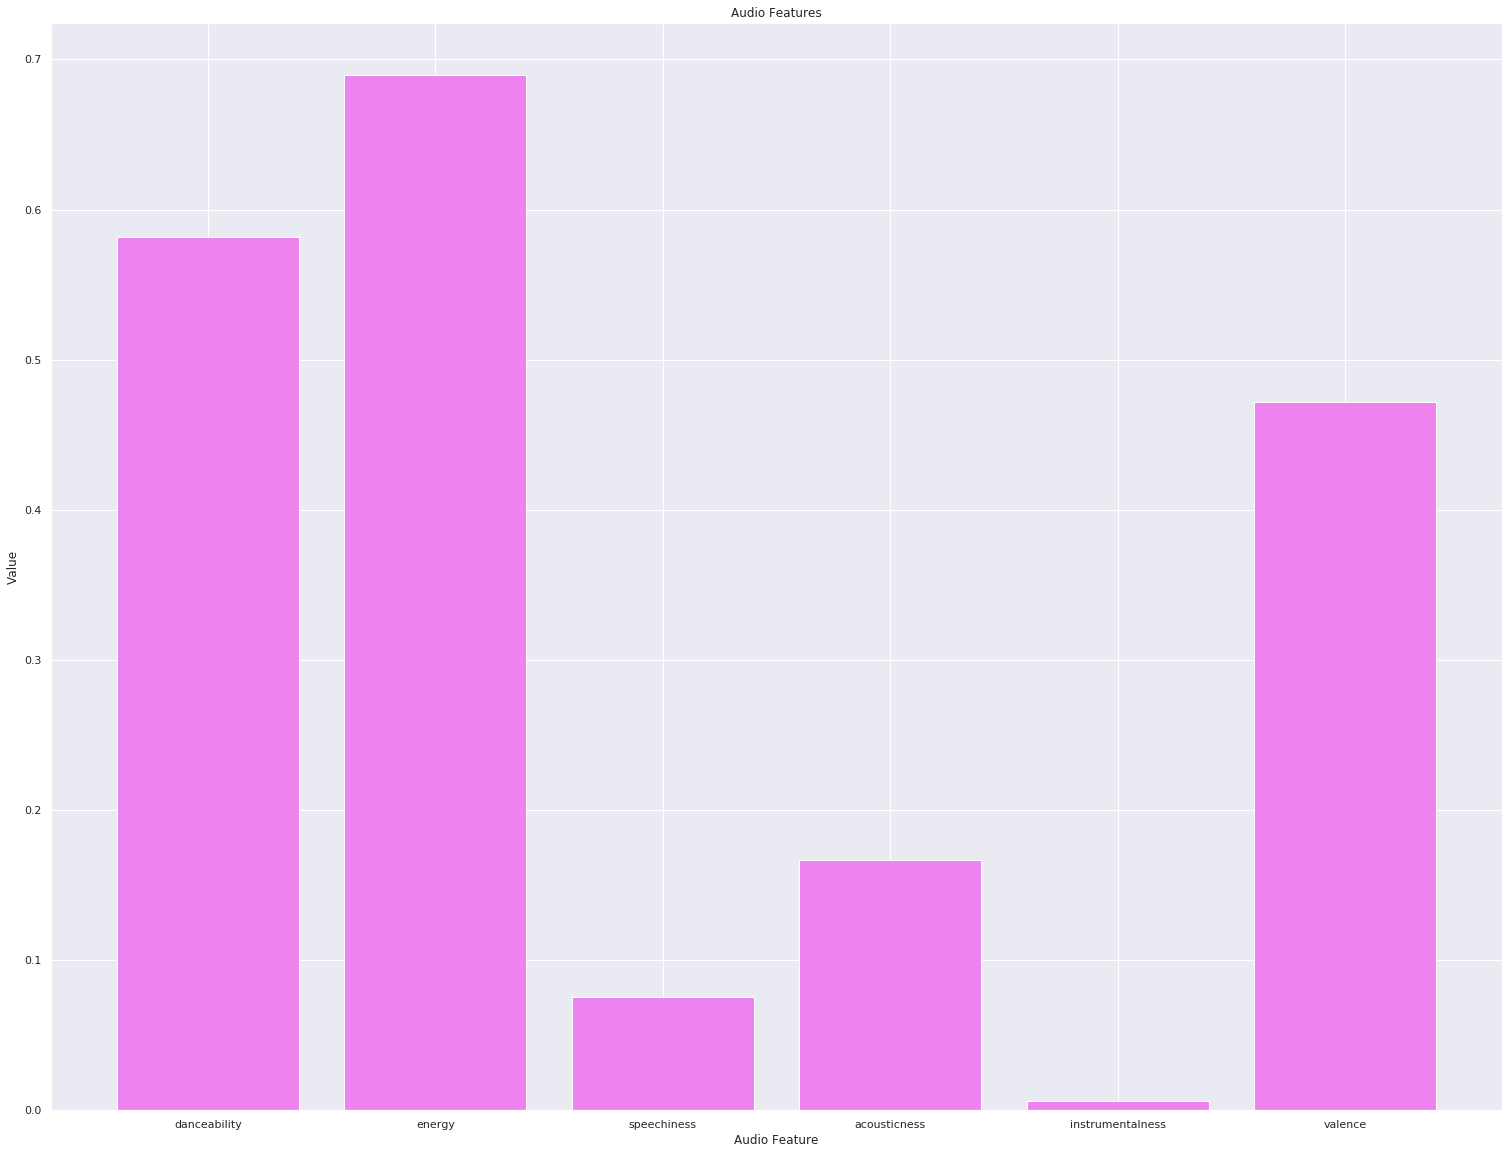

In [17]:
ax = plt.bar(audio_features_df.loc[:, features].mean().keys(), audio_features_df.loc[:, features].mean(), 
             color='violet')
plt.xlabel('Audio Feature')
plt.ylabel('Value')
plt.title('Audio Features')
plt.show()

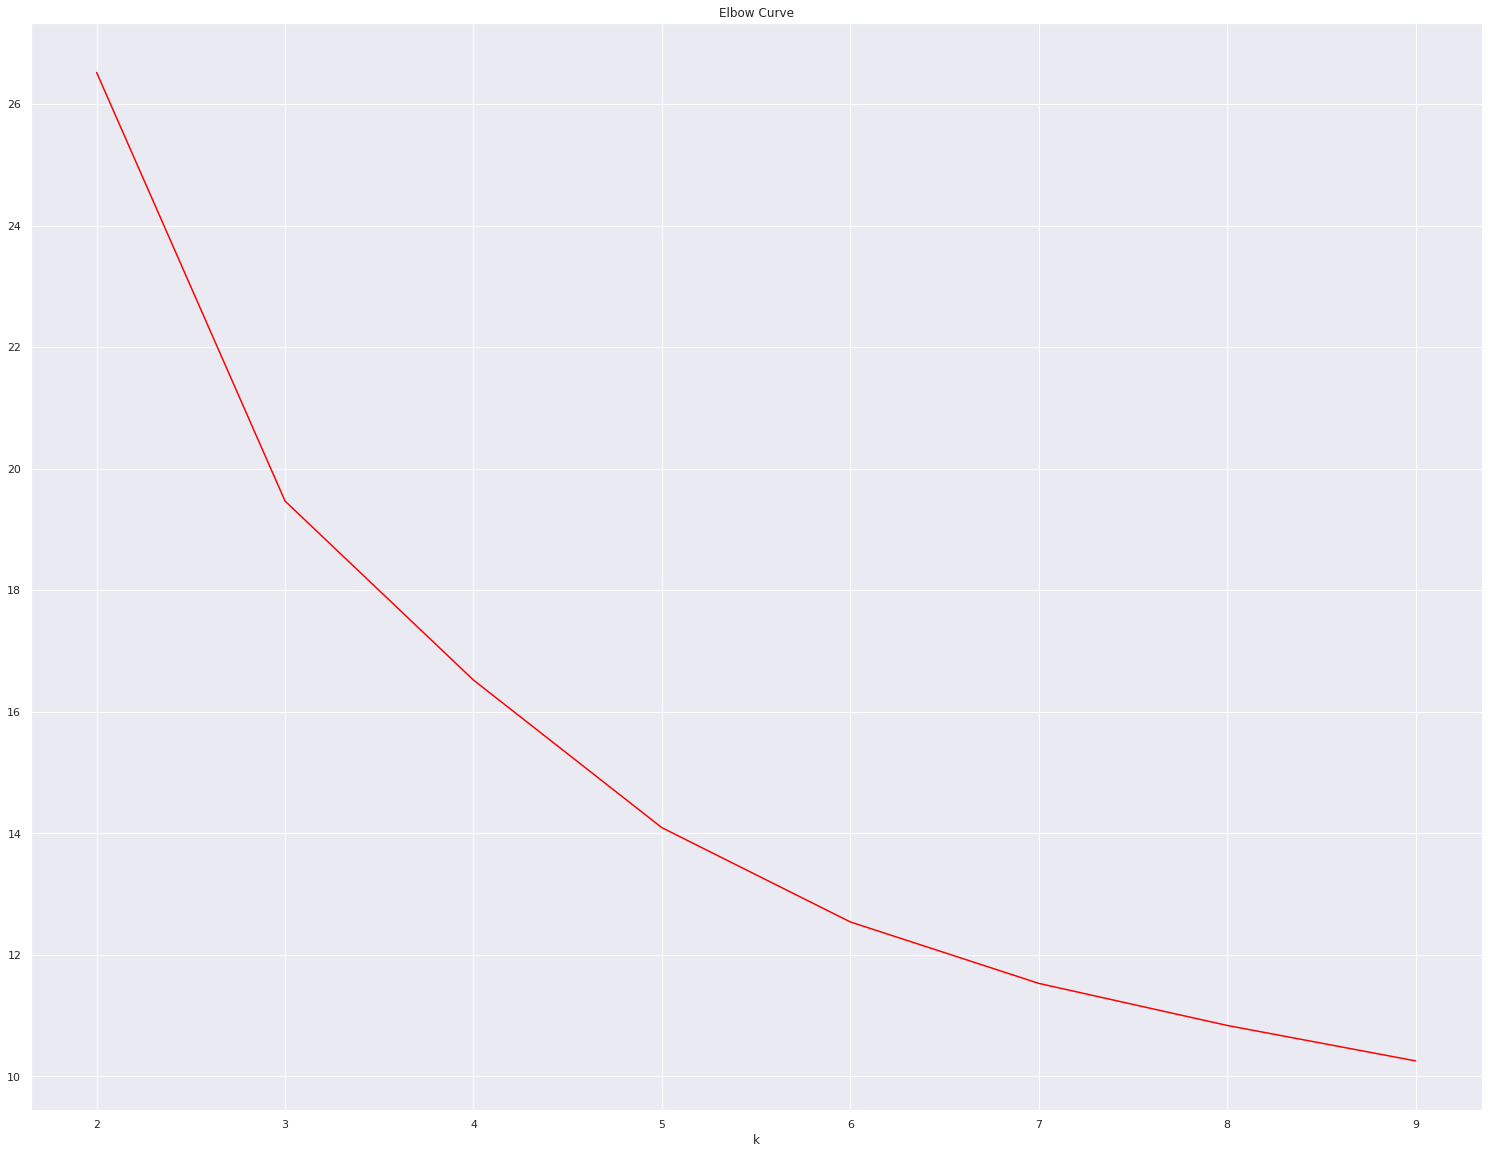

In [18]:
#Clustering songs
from sklearn.cluster import KMeans

#In order to cluster the songs, we are going to use KMeans algorithm, which finds a certain (predefined) 'k'
#number of clusters (group of data points that are grouped together due to similarities in their features) 
#in a set of data
#We are going to use the 'Elbow method' to find an optimal number of clusters 'k'
X = audio_features_df[features]
distorsions = []
for k in range(2,10):
    model = KMeans(n_clusters=k)
    model.fit(X)
    distorsions.append(model.inertia_)

plt.plot(range(2,10), distorsions, color='red')
plt.grid(True)
plt.xlabel('k')
plt.title('Elbow Curve')
plt.show()

In [19]:
#Training data
X = audio_features_df[features]
model = KMeans(n_clusters=4)
model.fit(X)

y = model.predict(X) #Each song goes to the cluster which has the most similarities in their features
y

array([3, 2, 2, 2, 3, 3, 0, 0, 3, 0, 3, 2, 2, 2, 0, 2, 1, 0, 3, 2, 0, 1,
       3, 1, 1, 2, 2, 0, 3, 3, 0, 0, 2, 3, 3, 2, 3, 3, 3, 2, 3, 1, 1, 3,
       3, 2, 2, 0, 3, 0, 0, 0, 1, 3, 1, 0, 2, 1, 2, 3, 1, 1, 0, 2, 0, 1,
       1, 3, 3, 3, 3, 0, 3, 0, 2, 2, 2, 1, 3, 1, 3, 1, 3, 2, 2, 2, 3, 3,
       2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 3, 2, 1, 3,
       3, 3, 0, 3, 3, 0, 3, 1, 2, 3, 3, 3, 3, 3, 2, 0, 3, 3, 3, 3, 3, 3,
       2, 2, 0, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       3, 1, 1, 3, 3, 3, 1, 1, 1, 2, 1, 1, 1, 3, 3, 1, 3, 1, 1, 2, 3, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 3, 1, 0, 1, 3, 1, 3, 1, 1, 0,
       3, 1, 0, 2, 3, 0, 0, 2, 0, 0, 3, 3, 2, 0, 0, 3, 2, 0, 2, 2, 3, 3,
       0, 1, 2, 3, 1, 2, 3, 3, 0, 2, 2, 1, 0, 1, 2, 3, 1, 1, 1, 0, 0, 3,
       3, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 3, 0, 0, 3, 3, 3, 1, 1, 1, 3,
       3, 1, 1, 2, 1, 3, 0, 3, 3, 2, 3, 1, 0, 0, 3, 2, 3, 2], dtype=int32)

In [20]:
centers = model.cluster_centers_
centers

array([[0.60085714, 0.48236735, 0.09864898, 0.60155102, 0.0041719 ,
        0.40633061],
       [0.4596962 , 0.80473418, 0.06920886, 0.03371571, 0.01156911,
        0.35295316],
       [0.649     , 0.57354412, 0.07166324, 0.13446412, 0.004396  ,
        0.37915147],
       [0.62893023, 0.7939186 , 0.07145349, 0.06677234, 0.00437878,
        0.69187209]])

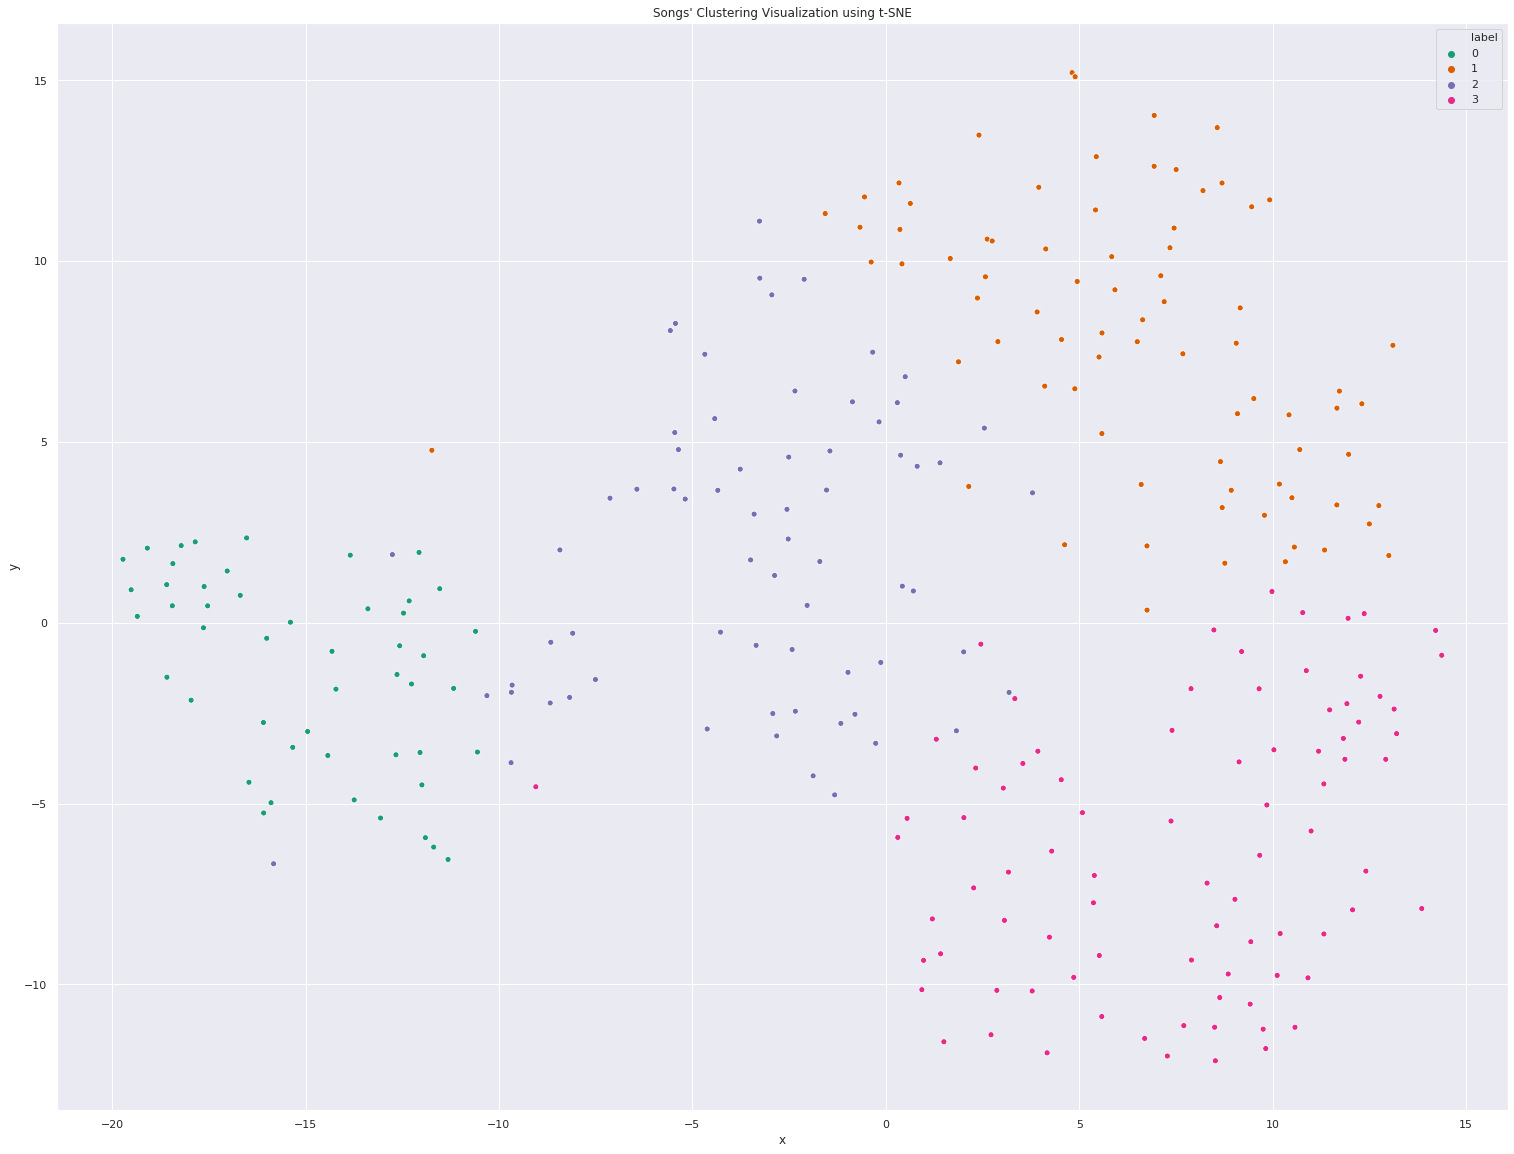

In [21]:
#Since we are working with 6 features, we are going to apply dimensionality reduction techniques in order 
#to visualize our data in 2d. We are going to test PCA and t-SNE algorithms
#t-SNE seeks to preserve small pairwise distances 

from sklearn.manifold import TSNE

tsne_obj = TSNE()
tsne = tsne_obj.fit_transform(X)

tsne_df = pd.DataFrame(tsne, columns=['x', 'y'])
tsne_df['label'] = y

sns.scatterplot(data=tsne_df, x='x', y='y', hue='label', palette='Dark2')
plt.title("Songs' Clustering Visualization using t-SNE")
plt.show()

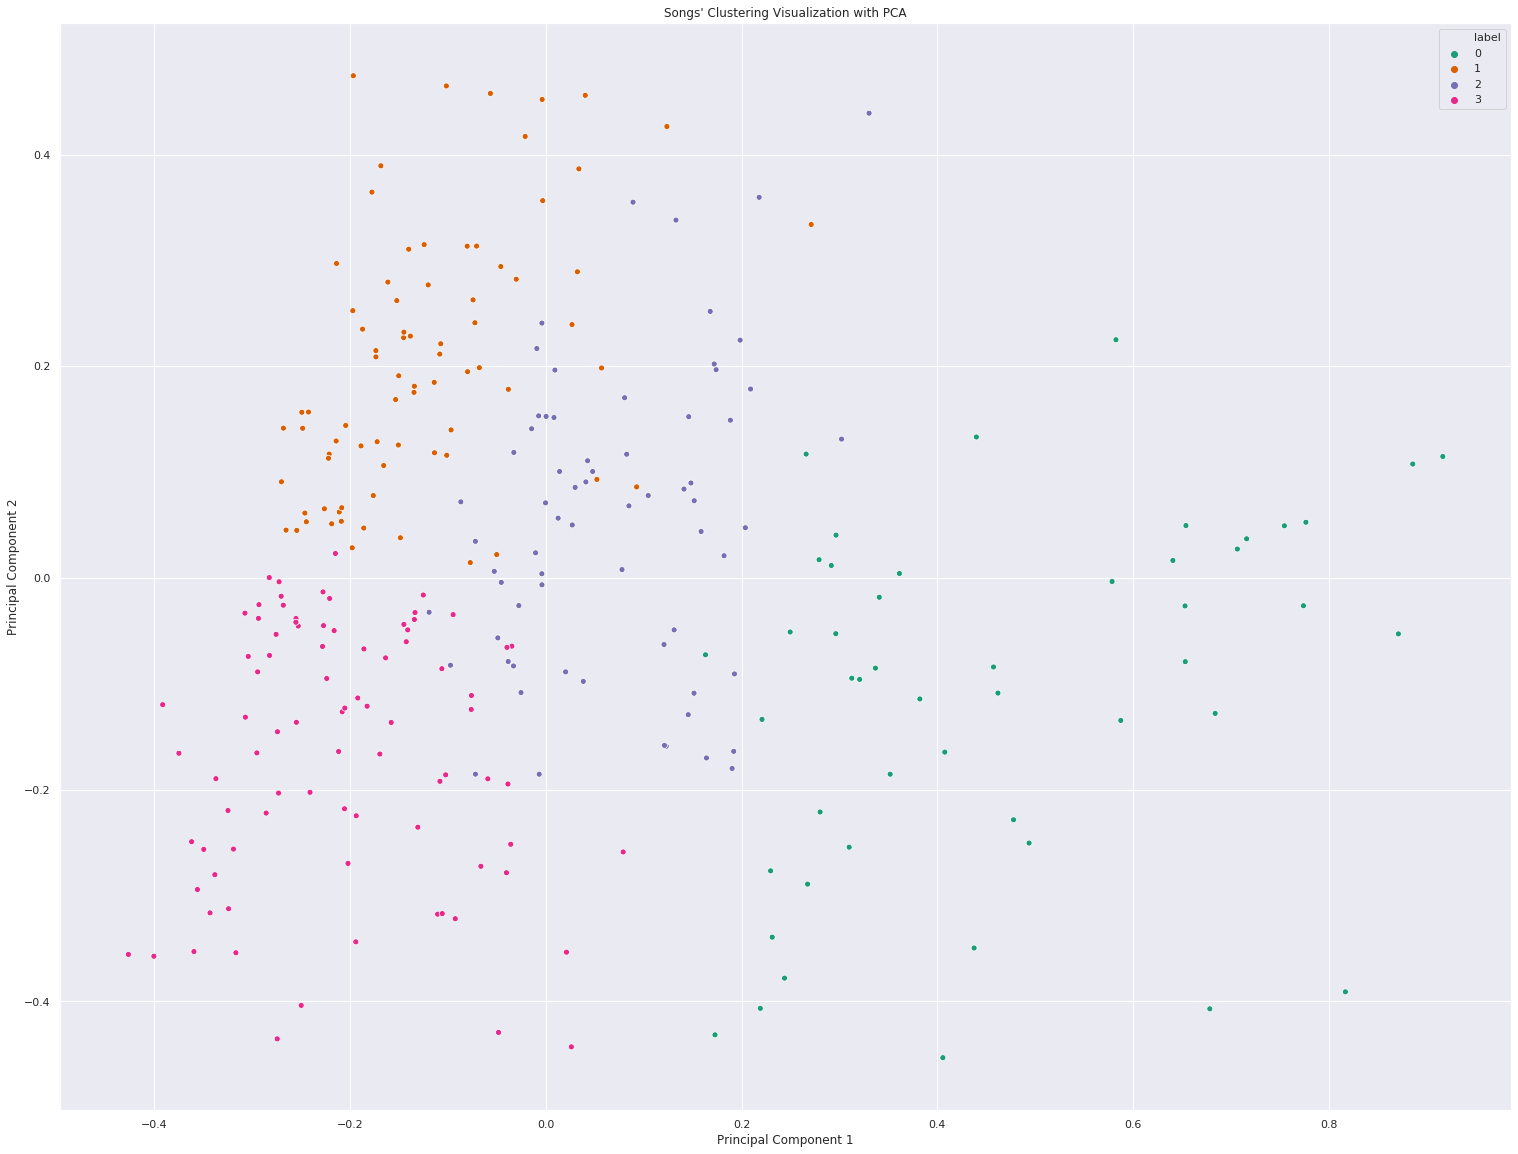

In [22]:
#PCA seeks to preserve large pairwise distances to maximize variance

from sklearn.decomposition import PCA

pca = PCA(n_components=2) #2 dimensions
pc = pca.fit_transform(X) #Fit the model with X and apply the dimensionality reduction on X

#Creating a data frame with the results from the dimensionality reduction (in order to display the data in 2d)
pca_df = pd.DataFrame(pc, columns=['Principal Component 1', 'Principal Component 2']) 
pca_df['label'] = y

sns.scatterplot(data=pca_df, x='Principal Component 1', y='Principal Component 2', hue='label', palette='Dark2')
plt.title("Songs' Clustering Visualization with PCA")
plt.show()

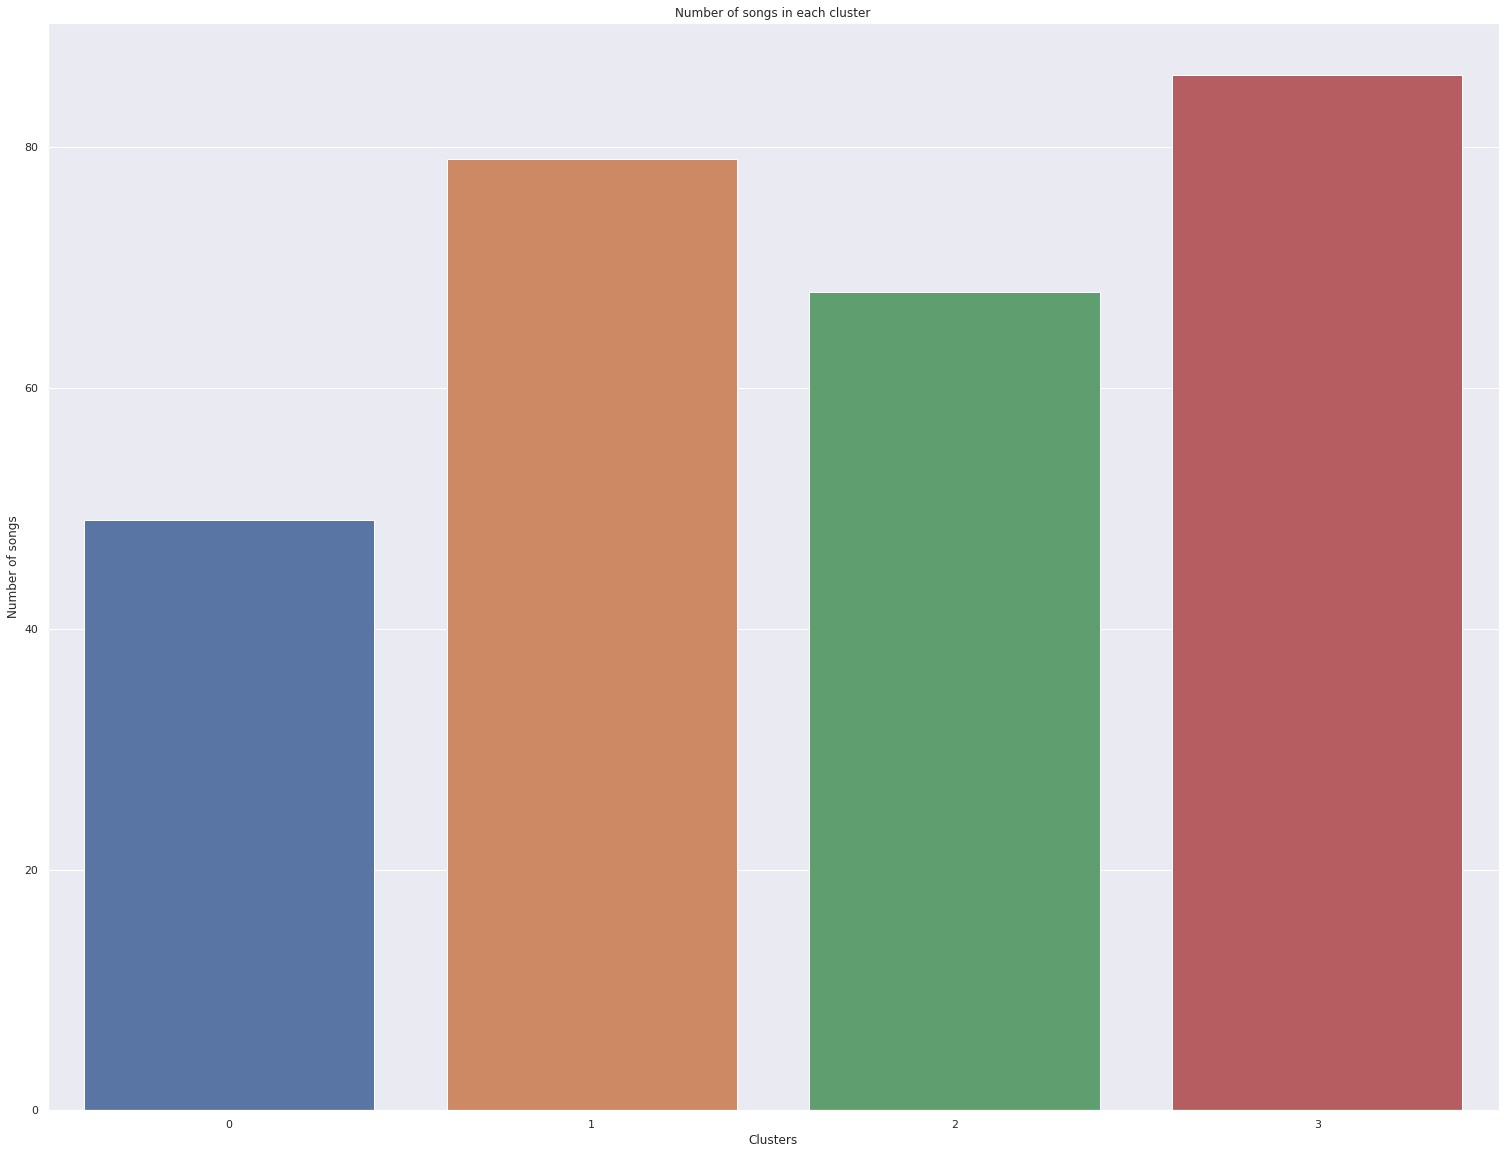

In [23]:
sns.countplot(y)
plt.xlabel('Clusters')
plt.ylabel('Number of songs')
plt.title('Number of songs in each cluster')
plt.show()

In [24]:
#Our data frame now has a target column (indicating the cluster in which each song is grouped)
audio_features_df.loc[:, 'label'] = y
audio_features_df.head(10)

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,label
0,Fluorescent Adolescent,Arctic Monkeys,0.651,0.823,1,-5.148,0,0.0282,0.00193,0.000058,...,0.817,112.148,audio_features,2HYaqJitHc9qiG68vc0JIm,spotify:track:2HYaqJitHc9qiG68vc0JIm,https://api.spotify.com/v1/tracks/2HYaqJitHc9q...,https://api.spotify.com/v1/audio-analysis/2HYa...,179533,4,3
1,My My My!,Troye Sivan,0.699,0.479,1,-7.830,1,0.0919,0.00433,0.000096,...,0.462,102.959,audio_features,2Tq2R8sRftNEqdgJK5HadO,spotify:track:2Tq2R8sRftNEqdgJK5HadO,https://api.spotify.com/v1/tracks/2Tq2R8sRftNE...,https://api.spotify.com/v1/audio-analysis/2Tq2...,204727,4,2
2,Tear in My Heart,Twenty One Pilots,0.655,0.632,2,-4.802,1,0.0489,0.01890,0.000000,...,0.447,120.113,audio_features,3bnVBN67NBEzedqQuWrpP4,spotify:track:3bnVBN67NBEzedqQuWrpP4,https://api.spotify.com/v1/tracks/3bnVBN67NBEz...,https://api.spotify.com/v1/audio-analysis/3bnV...,188493,4,2
3,IDGAF,Dua Lipa,0.836,0.544,7,-5.975,1,0.0943,0.04030,0.000000,...,0.510,97.028,audio_features,5BG3hnp2SmFmoBIs3YTqsm,spotify:track:5BG3hnp2SmFmoBIs3YTqsm,https://api.spotify.com/v1/tracks/5BG3hnp2SmFm...,https://api.spotify.com/v1/audio-analysis/5BG3...,217947,4,2
4,Snap Out Of It,Arctic Monkeys,0.728,0.638,5,-6.455,0,0.0336,0.24900,0.000000,...,0.872,130.014,audio_features,0NdTUS4UiNYCNn5FgVqKQY,spotify:track:0NdTUS4UiNYCNn5FgVqKQY,https://api.spotify.com/v1/tracks/0NdTUS4UiNYC...,https://api.spotify.com/v1/audio-analysis/0NdT...,193030,4,3
5,Bad At Love,Halsey,0.664,0.753,0,-3.589,1,0.0323,0.05700,0.000000,...,0.540,118.253,audio_features,2TBQoW7s6iwKcg139ssqie,spotify:track:2TBQoW7s6iwKcg139ssqie,https://api.spotify.com/v1/tracks/2TBQoW7s6iwK...,https://api.spotify.com/v1/audio-analysis/2TBQ...,181279,4,3
6,Sweet Creature,Harry Styles,0.427,0.262,7,-8.541,1,0.0276,0.74600,0.000000,...,0.228,104.085,audio_features,5kRPPEWFJIMox5qIkQkiz5,spotify:track:5kRPPEWFJIMox5qIkQkiz5,https://api.spotify.com/v1/tracks/5kRPPEWFJIMo...,https://api.spotify.com/v1/audio-analysis/5kRP...,224867,4,0
7,Meet Me in the Hallway,Harry Styles,0.537,0.383,2,-6.528,1,0.0247,0.74700,0.000250,...,0.339,104.252,audio_features,4u9Y4Z9i9VaAbBK7rW1Rha,spotify:track:4u9Y4Z9i9VaAbBK7rW1Rha,https://api.spotify.com/v1/tracks/4u9Y4Z9i9VaA...,https://api.spotify.com/v1/audio-analysis/4u9Y...,227200,4,0
8,Dug My Heart,BØRNS,0.568,0.809,9,-5.474,1,0.1010,0.02650,0.000061,...,0.600,166.044,audio_features,4o6LaVzeB3Ny7oQCBjT053,spotify:track:4o6LaVzeB3Ny7oQCBjT053,https://api.spotify.com/v1/tracks/4o6LaVzeB3Ny...,https://api.spotify.com/v1/audio-analysis/4o6L...,189573,4,3
9,All These Years,Camila Cabello,0.732,0.436,1,-7.409,0,0.1170,0.60900,0.000000,...,0.475,94.852,audio_features,4XLu3tTSZiPFVC9mmuR6Zp,spotify:track:4XLu3tTSZiPFVC9mmuR6Zp,https://api.spotify.com/v1/tracks/4XLu3tTSZiPF...,https://api.spotify.com/v1/audio-analysis/4XLu...,164373,4,0


['Sweet Creature', 'Meet Me in the Hallway', 'All These Years', 'Eastside (with Halsey & Khalid)', 'lovely (with Khalid)', 'Lucky Strike', 'Neon Gravestones', 'Leave the City', 'West Coast', 'Dream', 'come out and play', 'bellyache', 'ocean eyes', "The Man Who Can't Be Moved", 'Dying in LA', "Say You Won't Let Go", 'NASA', '7 rings', 'Malibu Nights', 'ILYSB', '13', 'Trouble', 'Roots', 'I Can’t Get Enough (benny blanco, Selena Gomez, J Balvin, Tainy)', 'Drunk', 'Easy', 'waiting on the weekend', 'From the Dining Table', 'Girl Crush - Recorded at Metropolis Studios, London', "fuck, i'm lonely (with Anne-Marie) - from “13 Reasons Why: Season 3”", 'Sims', 'Sad Forever', 'I Like Me Better', 'Cherry', 'Falling', 'Take Me To Church', 'To Be So Lonely', 'Memories', 'Used To Love (with Dean Lewis)', 'Feel It Twice', 'Used to This', "fuck, i'm lonely (with Anne-Marie)", "There's No Way (feat. Julia Michaels)", 'Changes', "Fool's Gold - Recorded At RAK Studios, London", 'Easier', 'Put A Little Lov

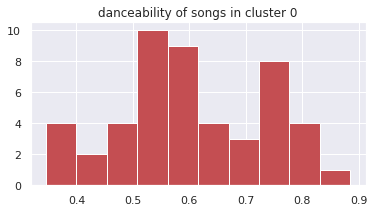

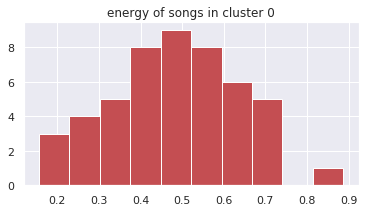

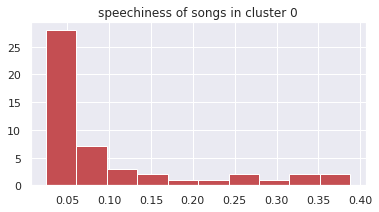

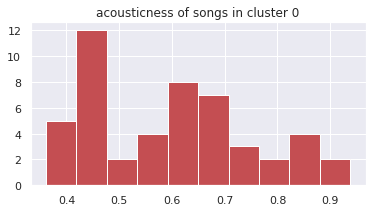

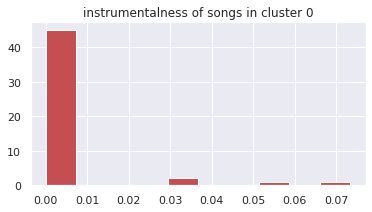

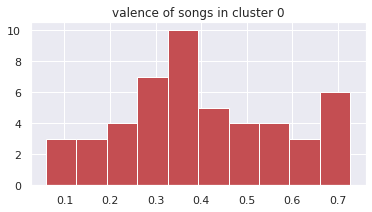

In [25]:
l0 = []
l1 = []
l2 = []
l3 = []
for k,v in enumerate(audio_features_df['track']):
    if y[k] == 0:
        l0.append(v)
    elif y[k] == 1:
        l1.append(v)
    elif y[k] == 2:
        l2.append(v)
    else:
        l3.append(v)
        
        
print(l0) #cluster 0
for feature in features:
    plt.subplot(audio_features_df.loc[:,feature][audio_features_df['label'] == 0].hist(color='r', figsize=(6,3)))
    plt.title("%s of songs in cluster 0" % feature)
    plt.show()
    
mean_cluster0 = audio_features_df.loc[:,features][audio_features_df['label'] == 0].mean()

['Love It If We Made It', 'Starlight', 'Song On Fire', 'The Hype', 'The Greatest Show', 'Roaring 20s', 'Uprising', 'Nine in the Afternoon', 'Nothing', 'Girl That You Love', 'Hurricane', 'House of Memories', 'The Ballad of Mona Lisa', 'Sometimes', 'Youngblood', 'Who Do You Love', 'HEAVEN', 'FOOLS', 'WILD', 'R U Mine?', 'Trees', 'Skin and Bones', 'Shake Me Down', 'Psycho', 'Thinking Bout You', 'Shameless', 'Kill My Mind', 'Style', 'Longshot', '7', 'Cocoon', 'Basically', '2all', 'Hysteria', "Don't Look Back in Anger - Remastered", 'Wonderwall - Remastered', 'Undercover Martyn', 'Champagne Supernova - Remastered', 'Stop Crying Your Heart Out', 'Pacifier', 'Amsterdam', 'The River', 'Thought Contagion', 'Wall Of Glass', 'Amsterdam', 'Tiptoe', 'Round And Round', 'Shots', 'Thief', 'Who We Are', 'California', 'Polygraph Eyes', '11 Minutes (with Halsey feat. Travis Barker)', "I Think I'm OKAY (with YUNGBLUD & Travis Barker)", 'Anarchist', 'Psychotic Kids', 'Nice To Meet Ya', 'Kiwi', 'Ode to Slee

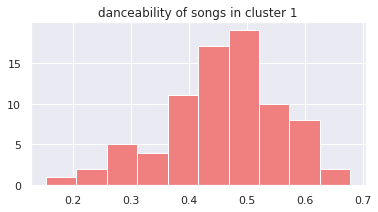

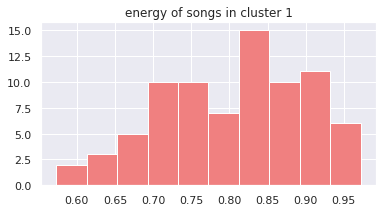

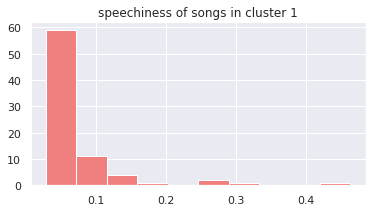

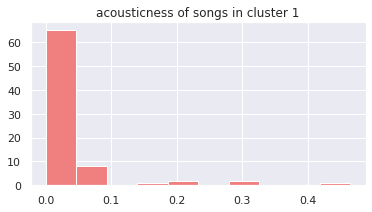

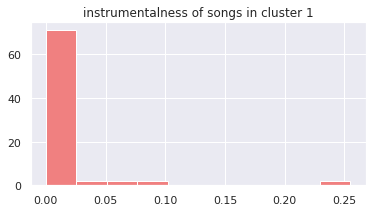

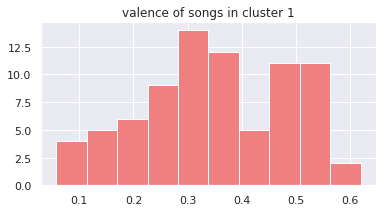

In [26]:
print(l1) #cluster 1
for feature in features:
    plt.subplot(audio_features_df.loc[:,feature][audio_features_df['label'] == 1].hist(color='lightcoral',
                                                                                       figsize=(6,3)))
    plt.title("%s of songs in cluster 1" % feature)
    plt.show()
    
mean_cluster1 = audio_features_df.loc[:,features][audio_features_df['label'] == 1].mean()

['My My My!', 'Tear in My Heart', 'IDGAF', 'In the Dark', 'Jumpsuit', 'Nico And The Niners', 'Natural', 'Migraine', 'Chlorine', 'Smithereens', 'Morph', 'Death of a Bachelor', 'Without Me', 'Seventeen', 'Smoke And Mirrors', 'Breakeven', 'sweetener', 'Gasoline', "break up with your girlfriend, i'm bored", 'fake smile', 'in my head', 'Amnesia', 'Two of Us', '18', 'Thick And Thin', 'Thru These Tears', "I Don't Wanna Love You Anymore", 'Super Far', 'If You See Her', "Valentine's Day", 'Taking Me Back', 'Bloom', 'Plum', 'Arabella', 'Mardy Bum', 'Cigarette Daydreams', 'Beautiful People (feat. Khalid)', 'Way To Break My Heart (feat. Skrillex)', 'Car Radio', 'Hometown', 'Never Be the Same', 'Liar', 'I’m So Sorry', 'I Bet My Life', 'Lights Up', 'Mean It', 'Feelings', 'Starving', 'Two Ghosts', 'Most Girls', 'Fine Line', 'Afterlife', 'A.M.', 'My Oh My (feat. DaBaby)', 'Graveyard', 'Living Proof', 'Fearless', 'Summer Days (feat. Macklemore & Patrick Stump of Fall Out Boy)', 'Modern Loneliness', 'Lo

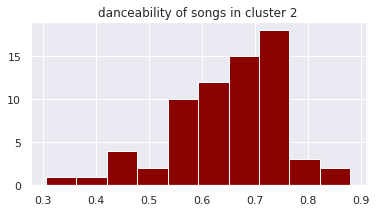

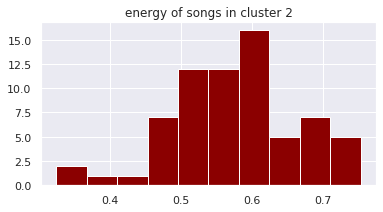

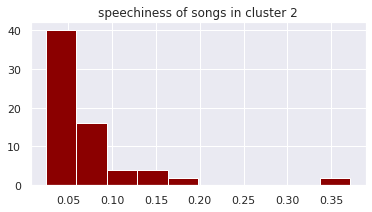

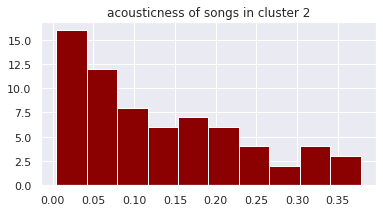

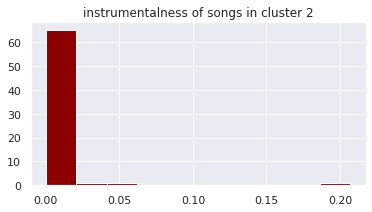

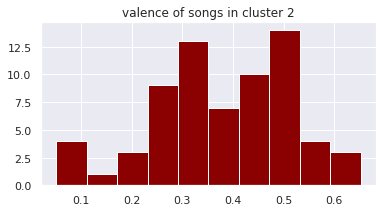

In [27]:
print(l2) #cluster 2
for feature in features:
    plt.subplot(audio_features_df.loc[:,feature][audio_features_df['label'] == 2].hist(color='darkred',
                                                                                       figsize=(6,3)))
    plt.title("%s of songs in cluster 2" % feature)
    plt.show()
    
mean_cluster2 = audio_features_df.loc[:,features][audio_features_df['label'] == 2].mean()

['Fluorescent Adolescent', 'Snap Out Of It', 'Bad At Love', 'Dug My Heart', 'She Loves Control', 'Holding on to You', 'Machine', 'Cut My Lip', 'Legend', 'Say Amen (Saturday Night)', 'High Hopes', 'I Write Sins Not Tragedies', "Don't Threaten Me with a Good Time", 'This Is Gospel', 'Kiss and Make Up', 'Hallelujah', "Emperor's New Clothes", 'All About It (feat. Ed Sheeran)', 'Pressure', 'Nicotine', 'LA Devotee', 'One of the Drunks', 'Vegas Lights', 'Girls / Girls / Boys', 'bloodline', 'Bad Decisions', 'Want You Back', 'Moving Along', "i'm so tired...", 'My Fault', "Ain't No Rest For The Wicked - Original Version", 'The Judge', 'Polarize', 'Guns for Hands', 'Ready To Let Go', 'Not Today', 'Social Cues', 'Cross Me (feat. Chance the Rapper & PnB Rock)', 'South of the Border (feat. Camila Cabello & Cardi B)', 'You Need To Calm Down', 'Night Running', 'Cold Cold Cold', 'Antisocial (with Travis Scott)', 'Take Me Back to London (feat. Stormzy)', 'Remember The Name (feat. Eminem & 50 Cent)', 'No

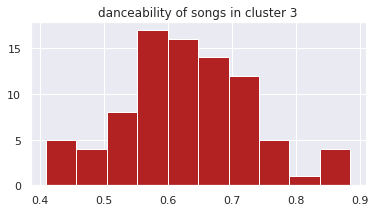

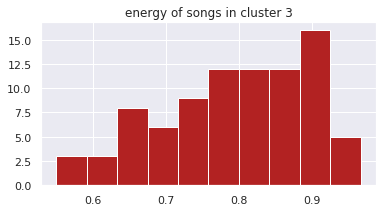

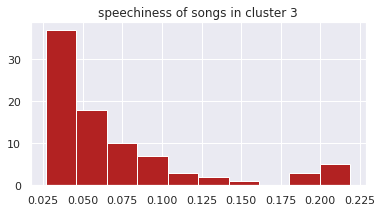

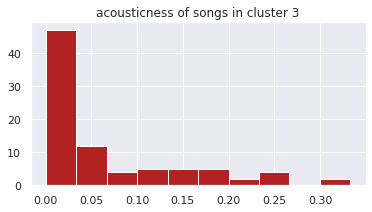

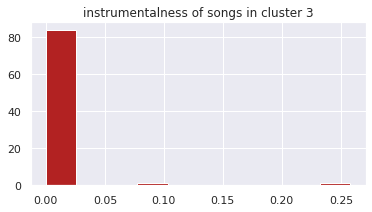

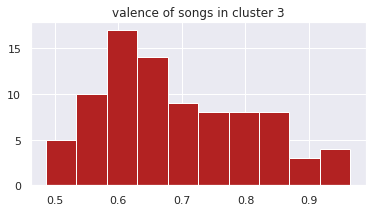

In [28]:
print(l3) #cluster 3
for feature in features:
    plt.subplot(audio_features_df.loc[:,feature][audio_features_df['label'] == 3].hist(color='firebrick',
                                                                                       figsize=(6,3)))
    plt.title("%s of songs in cluster 3" % feature)
    plt.show()
    
mean_cluster3 = audio_features_df.loc[:,features][audio_features_df['label'] == 3].mean()

In [29]:
mean_df = pd.DataFrame(mean_cluster0, columns=['Cluster 0'])
mean_df['Cluster 1'] = mean_cluster1
mean_df['Cluster 2'] = mean_cluster2
mean_df['Cluster 3'] = mean_cluster3
mean_df

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
danceability,0.600857,0.459696,0.649000,0.628930
energy,0.482367,0.804734,0.573544,0.793919
speechiness,0.098649,0.069209,0.071663,0.071453
acousticness,0.601551,0.033716,0.134464,0.066772
instrumentalness,0.004172,0.011569,0.004396,0.004379
valence,0.406331,0.352953,0.379151,0.691872


Insights:
- Cluster 0 is suitable for dancing, many songs are acoustic and they tend to be slow
- Cluster 1 has, majorly, fast/noisy songs and they don't tend to be cheerful
- Cluster 2 is the most suitable for dancing, many tracks are loud/noisy and they don't tend to cheerful
- Cluster 3 is suitable for dancing, tracks are majorly cheerful and loud/noisy

In [30]:
#Before building the model, we have to balance the data 
#SMOTE aims to balance class distribution by randomly increasing minority class examples by replicating them
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

balancing = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) #70%: train; 30%: test
columns = X_train.columns

balancing_X, balancing_y = balancing.fit_sample(X_train, y_train)
balancing_X = pd.DataFrame(data=balancing_X, columns=columns)
balancing_y = pd.DataFrame(data=balancing_y, columns=['label'])

Using TensorFlow backend.


In [31]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

#Cross validation for model selection
model = SVC(kernel='linear')
model2 = RandomForestClassifier()
model3 = SVC() #non-linear kernel
model4 = KNeighborsClassifier()

#estimator: the object to use to fit the data
#cv: determines the cross-validation splitting strategy
print('Accuracy of SVC (linear kernel): {:.2f}%'.format(cross_val_score(estimator=model, X=balancing_X,
                                                        y=balancing_y.values.ravel(), cv=5).mean()*100))

print('Accuracy of RandomForestClassifier: {:.2f}%'.format(cross_val_score(estimator=model2, X=balancing_X,
                                                            y=balancing_y.values.ravel(), cv=5).mean()*100))

print('Accuracy of SVC: {:.2f}%'.format(cross_val_score(estimator=model3, X=balancing_X, 
                                        y=balancing_y.values.ravel(), cv=5).mean()*100))

print('Accuracy of KNeighborsClassifier: {:.2f}%'.format(cross_val_score(estimator=model4, X=balancing_X,
                                                        y=balancing_y.values.ravel(), cv=5).mean()*100))

Accuracy of SVC (linear kernel): 96.31%
Accuracy of RandomForestClassifier: 93.86%
Accuracy of SVC: 96.72%
Accuracy of KNeighborsClassifier: 95.49%


In [32]:
#We can conclude that SVC (with non-linear kernel) seems to be the model that adjusts better in this data set
#Training
model = SVC() #rbf kernel
model.fit(balancing_X, balancing_y.values.ravel()) #ravel: Return a contiguous flattened array

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [42]:
#Prediction
y_pred_test = model.predict(X_test)

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
df = results_df.tail(25)
df

,Actual,Predicted
60,0,2
61,2,0
62,1,1
63,1,1
64,1,1
65,3,3
66,1,1
67,1,1
68,3,3
69,3,3


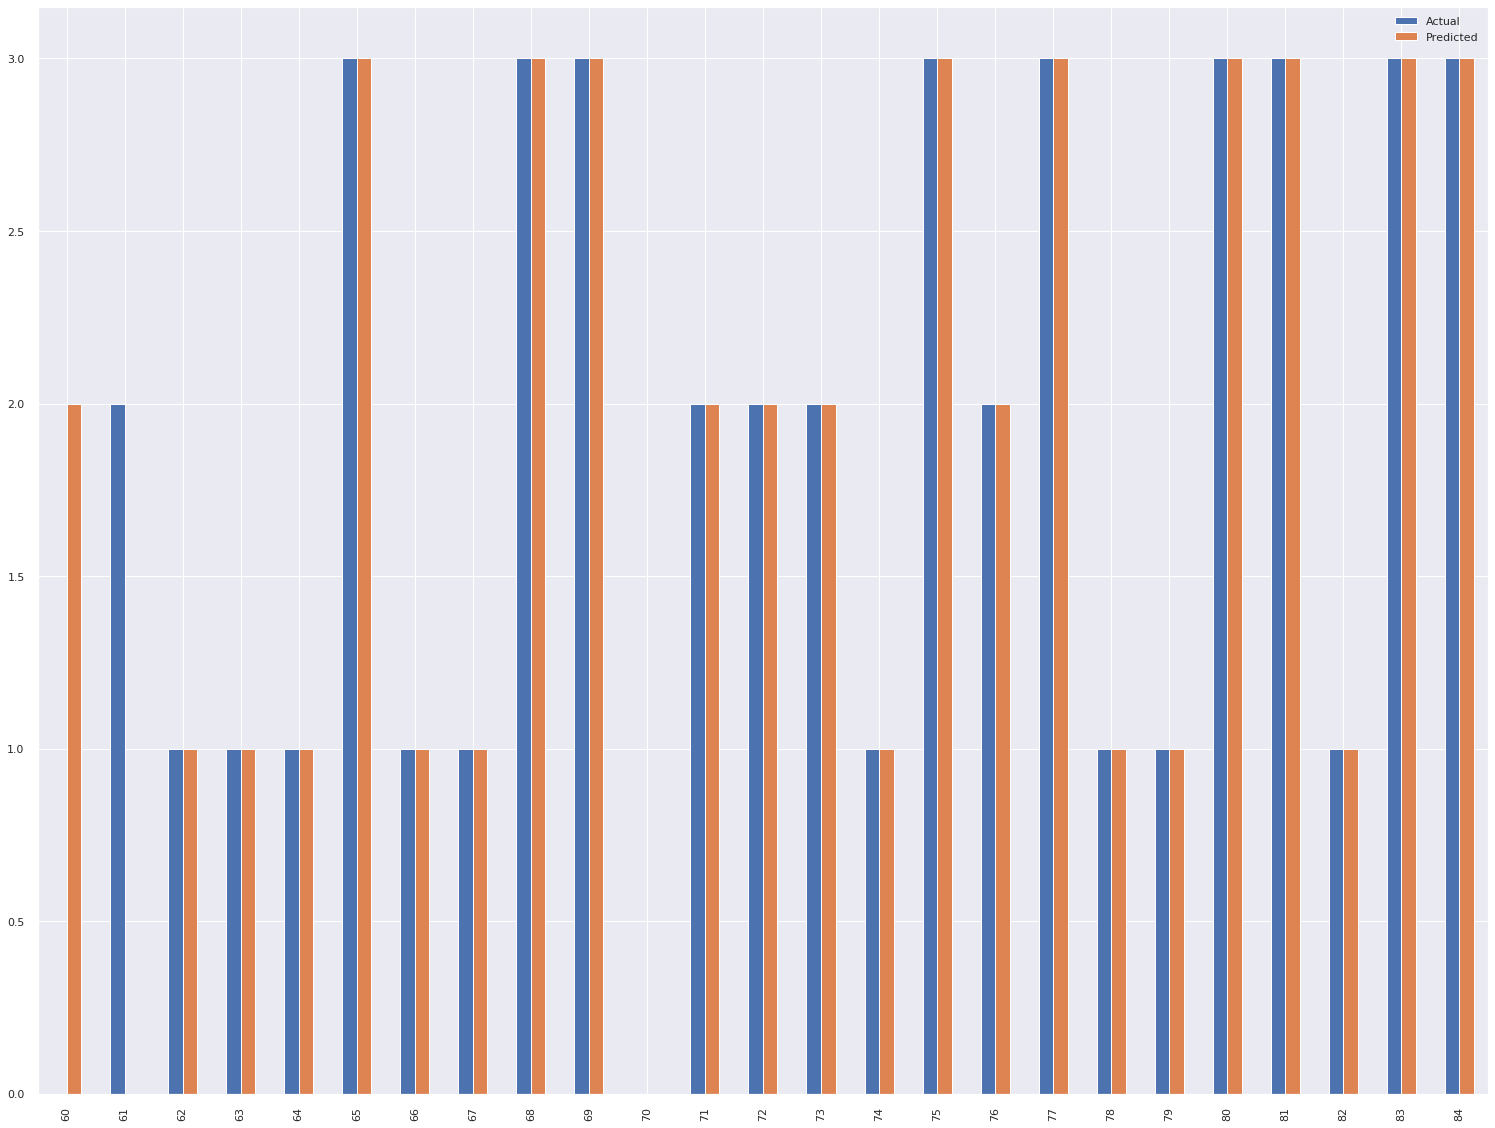

In [43]:
df.plot.bar()
plt.show()

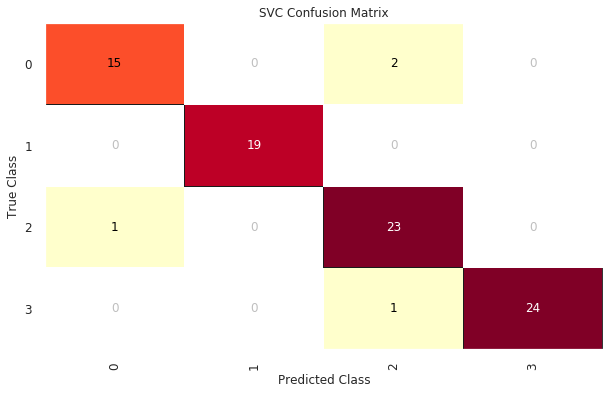

In [44]:
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ConfusionMatrix
import warnings
warnings.filterwarnings("ignore") #ignore warnings

sns.set(rc={'figure.figsize':(10,6)})

confusion_matrix = confusion_matrix(y_test, y_pred_test)

visualization = ConfusionMatrix(model)
visualization.fit(balancing_X, balancing_y)
visualization.score(X_test, y_test)
visualization.poof()
plt.show()

In [45]:
print('Model accuracy: {:.2f}%'.format(model.score(balancing_X, balancing_y)*100))

Model accuracy: 97.95%
